# **CNN -- Movie Genre Multilabel Classification based on Poster Images**

Author : Ganesh Kumar

EmailId : avkganesh@gmail.com

Description : 

In this notebook we are going to develop a deep neural network (CNN - multilabel classification) to solve the problem of movie genre classification based on movie poster images.

Data Source : https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html


# **Tensorflow Installation (Optional)**

This experiment is built on tensorflow 2.0 gpu, run a quick check to see the current version, if its not 2.0 then uninstall the current version and install the 2.0 gpu version

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip uninstall tensorflow 

In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 28kB/s 


# **Importing Libraries**

In [0]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
import csv
import numpy as np
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


# **Dataset**

The dataset is sourced from https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html . This is relatively large dataset. The best way to access this dataset is to download and upload it to your google drive. If you try uploading it google colab directly it might take ages for you to upload hence google drive is the best option. Once uploaded to google drive, access the google drive from google colab seamless through a library. The dataset can then be downloaded to google colab tmp directory through wget. 

There are 2 datasets

1.   Metadata
2.   Poster Data



In [0]:
from google.colab import drive
drive.mount('/Colab_Notebooks')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /Colab_Notebooks


In [0]:
!ls '/Colab_Notebooks/My Drive/Colab_Notebooks'

 CNN_movie_poster_tensorflow.ipynb   Movie_Poster_Dataset.zip
'DNN example.ipynb'		     Movie_Poster_Metadata.zip


## **Downloading Moster Poster Metadata**

In [0]:
metadata_dir = '/tmp/moviepostersmetadata'
os.mkdir(metadata_dir)

In [0]:
local_zip = '/Colab_Notebooks/My Drive/Colab_Notebooks/Movie_Poster_Metadata.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/moviepostersmetadata')
zip_ref.close()

## **Building a Master File List**

In [0]:
!ls '/tmp/moviepostersmetadata/groundtruth' > fileList.txt

In [0]:
fileList = []
with open("/content/fileList.txt") as f:
  for line in f:
    fileList.append(line.strip())

In [0]:
print("The number of files in metadata",len(fileList))

The number of files in metadata 36


## **Downloading Movies Posters**

All the movie posters have been placed in individual directories that reflect the year of the release

In [0]:
moviepostersdata_dir = '/tmp/moviepostersdata'
os.mkdir(moviepostersdata_dir)

In [0]:
local_zip = '/Colab_Notebooks/My Drive/Colab_Notebooks/Movie_Poster_Dataset.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/moviepostersdata')
zip_ref.close()

## **Data Consolidation**

A a single directory to consolidate all the posteres

In [0]:
allmoviepostersdata_dir = '/tmp/allmoviepostersdata'
os.mkdir(allmoviepostersdata_dir)

## **Master File List Table**

Iterate through all the metadata files and build a single master table. As you can see the that there are no posters for 1982 which needs be taken into account. Essentially there could be metadata for non existent poster files or there could be poster files for which there is no metadata. This data anomaly has to be factored in while processing the files.

In [0]:
moviePosterCount = []
movieYear = []
moviePosterFile = []
for loop in range(len(fileList)):
  dirName = os.path.join('/tmp/moviepostersdata/Movie_Poster_Dataset',fileList[loop].replace(".txt",""))
  imageFileList = os.listdir(dirName)
  print('DirName:',dirName,' Year:',fileList[loop].replace(".txt",""),':',len(imageFileList))
  moviePosterCount.append(len(imageFileList))
  movieYear.append(fileList[loop].replace(".txt",""))
  for file in imageFileList:
    moviePosterFile.append(file)

DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1980  Year: 1980 : 96
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1981  Year: 1981 : 89
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1982  Year: 1982 : 0
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1983  Year: 1983 : 114
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1984  Year: 1984 : 134
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1985  Year: 1985 : 150
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1986  Year: 1986 : 169
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1987  Year: 1987 : 187
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1988  Year: 1988 : 201
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1989  Year: 1989 : 180
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1990  Year: 1990 : 167
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1991  Year: 1991 : 171
DirName: /tmp/moviepostersdata/Movie_Poster_Dataset/1992  Year: 1992 : 175
DirName: /tmp/moviepostersdat

In [0]:
movieListDatabase = pd.DataFrame({'MovieYear':movieYear,'MoviePosterCount':moviePosterCount})

In [0]:
movieListDatabase.head()

,MovieYear,MoviePosterCount
0,1980,96
1,1981,89
2,1982,0
3,1983,114
4,1984,134


In [0]:
print("As per the metadata there has to be ",movieListDatabase["MoviePosterCount"].sum()," movie posters")

As per the metadata there has to be  8052  movie posters


## **Iterating through the Metadata to extract other relevant information**

Here is a quick and dirty version of reading the corresponding metadata files. During exploratory analysis, found some differences in the file metadata. Prior to 1982 the files could be read using "utf-8" while others could be read only using "utf-16". This is not the best code but serves the purpose of collecting relevant information.

In [0]:
movieList = []
movieDict ={}
count = 0
for loop in range(len(fileList)):
  recCount = 0
  if (movieListDatabase["MoviePosterCount"][loop]>0):
    recCount = 0
    fileName = os.path.join('/tmp/moviepostersmetadata/groundtruth',fileList[loop])
    try:
      with open(fileName,encoding='utf-8') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1
    except:
        with open(fileName,encoding='utf-16') as f:
          for line in f:
            modline = line.strip()
            if (modline=="{"):
              movieDict["Year"] = fileList[loop].replace(".txt","").strip()
              count = count+1
            elif (modline=="}"):
              movieList.append(movieDict)
              movieDict ={}
              count = count-1
            else:
              movieDict[modline.split(":")[0].replace('"', '').strip()] = modline.split(":")[1].replace('"', '').strip()
              recCount = recCount+1

In [0]:
movieList[1]

{'Actors': 'Gene Wilder, Richard Pryor, Georg Stanford Brown, JoBeth Williams,',
 'Awards': '1 nomination.,',
 'Box_office': '101,500,000,',
 'Country': 'USA,',
 'Director': 'Sidney Poitier,',
 'Genre': 'Comedy, Crime,',
 'Language': 'English,',
 'Metascore': '50',
 'Poster': 'http',
 'Rated': 'R,',
 'Released': '12 Dec 1980,',
 'Response': 'True,',
 'Runtime': '111 min,',
 'Title': 'Stir Crazy,',
 'Type': 'movie,',
 'Writer': 'Bruce Jay Friedman,',
 'Year': '1980',
 '_id': 'ObjectId(56fb860e71a0651b0c306f56),',
 'imdbID': 'tt0081562,',
 'imdbRating': '6.8,',
 'imdbVotes': '17,705,'}

## **Building the database of actual existent files**

Iterates through the movieList and find if there is a corresponding movie poster file existent. If its existent it moves them to the new directory that was created to place all the movie posters.

In [0]:
mainPosterDirectory = '/tmp/moviepostersdata/Movie_Poster_Dataset'
allmoviepostersdata_dir = '/tmp/allmoviepostersdata'
scrubbedMovieList = []
newFileList = []
for loop in range(len(movieList)):
  filePosterDirectory = os.path.join(mainPosterDirectory,movieList[loop]['Year'])
  fileName = movieList[loop]["imdbID"].replace(",","").strip()
  actualFileName = os.path.join(filePosterDirectory,fileName)+".jpg"
  if (len([file for file in newFileList if file==fileName])==0):
    newFileList.append(fileName)
    if(os.path.isfile(actualFileName)):
      scrubbedMovieList.append(movieList[loop])
      destFileName = movieList[loop]["imdbID"].replace(",","").strip()+".jpg"
      destFileNameWithPath = os.path.join(allmoviepostersdata_dir,destFileName)
      shutil.copyfile(actualFileName,destFileNameWithPath)

In [0]:
print("Size of scrubbedMovieList is ",len(scrubbedMovieList))

Size of scrubbedMovieList is  8052


In [0]:
allGenreList = []
for loop in range(len(scrubbedMovieList)):
  allGenreList.append(','.join([elem for elem in scrubbedMovieList[loop]['Genre'].split(",") if elem!=""]))

In [0]:
print(allGenreList)

['Action, Adventure, Fantasy', 'Comedy, Crime', 'Comedy', 'Action, Comedy', 'Comedy, War', 'Biography, Drama, Music', 'Action, Comedy', 'Adventure, Drama, Romance', 'Action, Comedy, Crime', 'Drama', 'Adventure, Comedy, Family', 'Drama, Romance, Western', 'Drama, Horror', 'Comedy, Romance', 'Comedy, Crime, Sci-Fi', 'Comedy, Sport', 'Drama', 'Comedy, Drama', 'Mystery, Thriller', 'Drama, Music, Romance', 'Action, Adventure, Sci-Fi', 'Biography, Drama', 'Action, Adventure, Comedy', 'Biography, Drama, Sport', 'Fantasy, Musical, Romance', 'Crime, Drama, Mystery', 'Comedy, Drama, Family', 'Fantasy, Horror', 'Horror, Sci-Fi, Thriller', 'Crime, Mystery, Thriller', 'Action, Drama, Romance', 'Music, Romance, Drama', 'Adventure, Comedy, Family', 'Adventure, Comedy, Crime', 'Action, Sci-Fi', 'Action, Biography, Comedy', 'Comedy, Romance', 'Western', 'Comedy', 'Horror, Romance', 'Comedy, Crime, Mystery', 'Comedy, Fantasy', 'Drama, Romance, Music', 'Comedy, Fantasy, History', 'Comedy', 'Comedy', 'Cri

In [0]:
fileNameList =[elem["imdbID"].replace(",","").strip()+".jpg" for elem in scrubbedMovieList]

In [0]:
print(fileNameList)

['tt0080684.jpg', 'tt0081562.jpg', 'tt0080339.jpg', 'tt0080377.jpg', 'tt0081375.jpg', 'tt0080549.jpg', 'tt0081529.jpg', 'tt0080453.jpg', 'tt0080455.jpg', 'tt0081283.jpg', 'tt0081353.jpg', 'tt0081696.jpg', 'tt0081505.jpg', 'tt0081480.jpg', 'tt0080520.jpg', 'tt0080487.jpg', 'tt0080474.jpg', 'tt0081060.jpg', 'tt0080661.jpg', 'tt0080948.jpg', 'tt0080745.jpg', 'tt0080678.jpg', 'tt0080472.jpg', 'tt0081398.jpg', 'tt0081777.jpg', 'tt0080365.jpg', 'tt0081207.jpg', 'tt0080749.jpg', 'tt0080360.jpg', 'tt0080569.jpg', 'tt0081259.jpg', 'tt0080888.jpg', 'tt0080861.jpg', 'tt0081439.jpg', 'tt0080736.jpg', 'tt0080907.jpg', 'tt0080863.jpg', 'tt0081071.jpg', 'tt0080739.jpg', 'tt0081383.jpg', 'tt0081249.jpg', 'tt0081268.jpg', 'tt0080556.jpg', 'tt0081751.jpg', 'tt0081032.jpg', 'tt0081698.jpg', 'tt0081163.jpg', 'tt0081031.jpg', 'tt0080731.jpg', 'tt0081554.jpg', 'tt0080881.jpg', 'tt0081485.jpg', 'tt0081534.jpg', 'tt0081656.jpg', 'tt0079285.jpg', 'tt0080754.jpg', 'tt0080402.jpg', 'tt0080724.jpg', 'tt0080756.jp

In [0]:
movieListDatabase = pd.DataFrame({'FileNames':fileNameList,'Genres':allGenreList})

In [0]:
movieListDatabase['Genres'] = movieListDatabase['Genres'].str.replace(" ","") 

In [0]:
movieListDatabase.head()

,FileNames,Genres
0,tt0080684.jpg,"Action,Adventure,Fantasy"
1,tt0081562.jpg,"Comedy,Crime"
2,tt0080339.jpg,Comedy
3,tt0080377.jpg,"Action,Comedy"
4,tt0081375.jpg,"Comedy,War"


In [0]:
movieListDatabase["Genres"]=movieListDatabase["Genres"].apply(lambda x:x.split(","))

In [0]:
movieListDatabase.head()

,FileNames,Genres
0,tt0080684.jpg,"[Action, Adventure, Fantasy]"
1,tt0081562.jpg,"[Comedy, Crime]"
2,tt0080339.jpg,[Comedy]
3,tt0080377.jpg,"[Action, Comedy]"
4,tt0081375.jpg,"[Comedy, War]"


In [0]:
genreList = ""
for loop in range(len(scrubbedMovieList)):
  if (genreList==""):
    genreList = scrubbedMovieList[loop]['Genre']
  else:
    genreList = genreList+","+scrubbedMovieList[loop]['Genre']

In [0]:
genreSet = [elem.strip() for elem in genreList.split(',') if elem!=""]

In [0]:
genreSet = set(genreSet)

In [0]:
genreSetList = list(genreSet)

In [0]:
genreSetList.sort()

In [0]:
print(genreSetList)

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


In [0]:
len(genreSetList)

25

## **One hot encode of the movie genres for each poster**

In [0]:
#Encoding genre list

genres_df = movieListDatabase

genres_df_cat = genres_df.Genres.apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')

In [0]:
genres_df_cat.head

<bound method NDFrame.head of       Action  Adventure  Fantasy  Comedy  ...  Short  N/A  Reality-TV  News
0          1          1        1       0  ...      0    0           0     0
1          0          0        0       1  ...      0    0           0     0
2          0          0        0       1  ...      0    0           0     0
3          1          0        0       1  ...      0    0           0     0
4          0          0        0       1  ...      0    0           0     0
...      ...        ...      ...     ...  ...    ...  ...         ...   ...
8047       0          0        0       0  ...      0    0           0     0
8048       0          0        0       1  ...      0    0           0     0
8049       0          0        0       0  ...      0    0           0     0
8050       0          0        0       0  ...      0    0           0     0
8051       0          0        0       0  ...      0    0           0     0

[8052 rows x 25 columns]>

In [0]:
movieListDatabaseGenreencode = pd.concat([genres_df, genres_df_cat], axis=1)
movieListDatabaseGenreencode.head

<bound method NDFrame.head of           FileNames                        Genres  ...  Reality-TV  News
0     tt0080684.jpg  [Action, Adventure, Fantasy]  ...           0     0
1     tt0081562.jpg               [Comedy, Crime]  ...           0     0
2     tt0080339.jpg                      [Comedy]  ...           0     0
3     tt0080377.jpg              [Action, Comedy]  ...           0     0
4     tt0081375.jpg                 [Comedy, War]  ...           0     0
...             ...                           ...  ...         ...   ...
8047  tt4159182.jpg                    [Thriller]  ...           0     0
8048  tt2265431.jpg      [Comedy, Drama, Romance]  ...           0     0
8049  tt3240784.jpg                 [Documentary]  ...           0     0
8050  tt2912776.jpg                [Drama, Music]  ...           0     0
8051  tt2241750.jpg                [Drama, Sport]  ...           0     0

[8052 rows x 27 columns]>

In [0]:
movieListDatabaseGenreencode_withoutgenres = movieListDatabaseGenreencode.drop(['Genres'],axis=1)

movieListDatabaseGenreencode_withoutgenres.head

<bound method NDFrame.head of           FileNames  Action  Adventure  Fantasy  ...  Short  N/A  Reality-TV  News
0     tt0080684.jpg       1          1        1  ...      0    0           0     0
1     tt0081562.jpg       0          0        0  ...      0    0           0     0
2     tt0080339.jpg       0          0        0  ...      0    0           0     0
3     tt0080377.jpg       1          0        0  ...      0    0           0     0
4     tt0081375.jpg       0          0        0  ...      0    0           0     0
...             ...     ...        ...      ...  ...    ...  ...         ...   ...
8047  tt4159182.jpg       0          0        0  ...      0    0           0     0
8048  tt2265431.jpg       0          0        0  ...      0    0           0     0
8049  tt3240784.jpg       0          0        0  ...      0    0           0     0
8050  tt2912776.jpg       0          0        0  ...      0    0           0     0
8051  tt2241750.jpg       0          0        0  ...     

## **Viewing the Posters and the respective Genres**

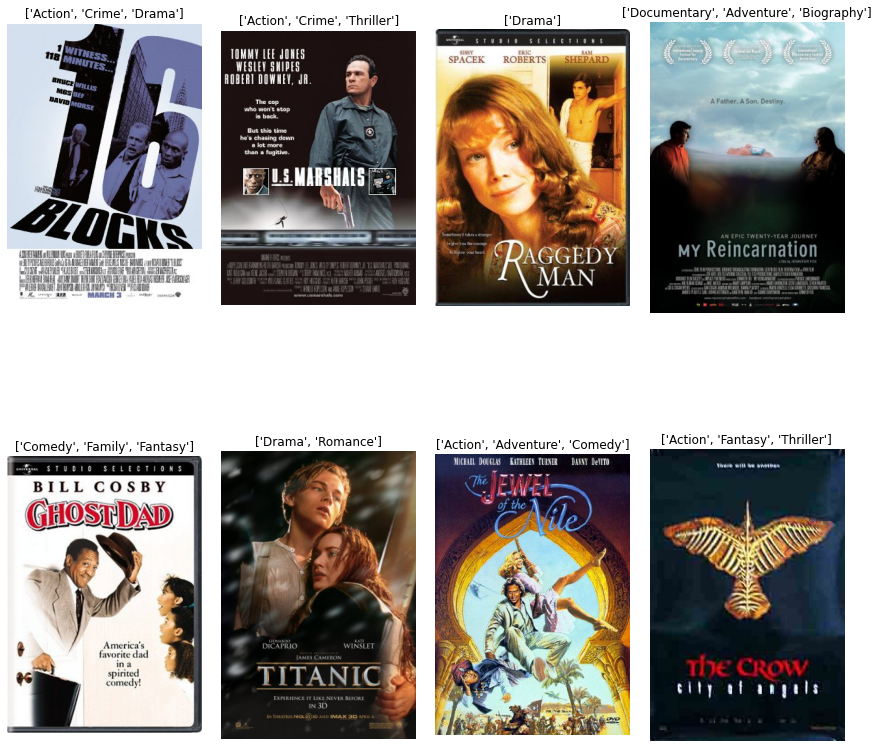

In [0]:
sampledMovies = movieListDatabase.sample(frac=.001)
maxCols = 4
maxRows = sampledMovies.shape[0]//maxCols
fig, axes = plt.subplots(nrows=maxRows, ncols=maxCols, figsize=(15,15))
row = 0
col = 0
for loop in range(sampledMovies.shape[0]):
    img_path = os.path.join(allmoviepostersdata_dir,sampledMovies.iloc[loop]["FileNames"])
    img = mpimg.imread(img_path)
    if (col > (maxCols-1)):
      row = row + 1
      col = 0
    axes[row, col].axis("off")
    axes[row, col].set_title(sampledMovies.iloc[loop]["Genres"])
    axes[row, col].imshow(img)  
    col = col + 1
plt.subplots_adjust(wspace=.10, hspace=.10)
plt.show()

## **Shuffling the dataset**

In [0]:
train_data = movieListDatabaseGenreencode_withoutgenres.sample(n = 6000).reset_index(drop=True)
valid_data = movieListDatabaseGenreencode_withoutgenres.sample(n = 40).reset_index(drop=True)

In [0]:
train_data.head

<bound method NDFrame.head of           FileNames  Action  Adventure  Fantasy  ...  Short  N/A  Reality-TV  News
0     tt0094383.jpg       0          0        0  ...      0    0           0     0
1     tt0914798.jpg       0          0        0  ...      0    0           0     0
2     tt0120373.jpg       0          0        0  ...      0    0           0     0
3     tt0087482.jpg       0          0        0  ...      0    0           0     0
4     tt0377071.jpg       0          0        0  ...      0    0           0     0
...             ...     ...        ...      ...  ...    ...  ...         ...   ...
5995  tt0118636.jpg       0          0        0  ...      0    0           0     0
5996  tt0093589.jpg       0          0        1  ...      0    0           0     0
5997  tt2034031.jpg       0          0        0  ...      0    0           0     0
5998  tt1051904.jpg       0          1        0  ...      0    0           0     0
5999  tt0405469.jpg       0          1        0  ...     

In [0]:
valid_data.shape

(40, 26)

# **Modelling**

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)
targetSize = 200

train_generator=train_datagen.flow_from_dataframe(
      dataframe=train_data,
      directory="/tmp/allmoviepostersdata",
      x_col="FileNames",
      y_col=genreSetList,
      batch_size=50,
      shuffle=True,
      class_mode="raw",
      target_size=(targetSize,targetSize)
)

valid_generator=valid_datagen.flow_from_dataframe(
      dataframe=valid_data,
      directory="/tmp/allmoviepostersdata",
      x_col="FileNames",
      y_col=genreSetList,
      batch_size=10,
      shuffle=True,
      class_mode="raw",
      target_size=(targetSize,targetSize)
)

Found 6000 validated image filenames.
Found 40 validated image filenames.


In [0]:
maxPooling = 2
filterSize = 3
nodeCount = 64
dropOut = 0.3

model = tf.keras.models.Sequential([                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),    
    tf.keras.layers.Dropout(dropOut),
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),    
    tf.keras.layers.Dropout(dropOut),                 
    tf.keras.layers.Conv2D(nodeCount, (filterSize, filterSize), activation='relu', input_shape=(targetSize, targetSize, 3), padding="valid"),
    tf.keras.layers.MaxPooling2D(maxPooling, maxPooling),       
    tf.keras.layers.Dropout(dropOut),                                         
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nodeCount, activation=tf.nn.relu), 
    tf.keras.layers.Dense(len(genreSetList), activation=tf.nn.sigmoid)])

model.compile(optimizer = "adam",
               loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        3

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
print("STEP_SIZE_TRAIN :",STEP_SIZE_TRAIN)
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
print("STEP_SIZE_VALID :",STEP_SIZE_VALID)
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

STEP_SIZE_TRAIN : 120
STEP_SIZE_VALID : 4
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
120/120 [==============================] - 640s 5s/step - loss: 0.2575 - accuracy: 0.2705 - val_loss: 0.2790 - val_accuracy: 0.3000
Epoch 2/50
120/120 [==============================] - 641s 5s/step - loss: 0.2357 - accuracy: 0.3015 - val_loss: 0.2533 - val_accuracy: 0.4000
Epoch 3/50
120/120 [==============================] - 633s 5s/step - loss: 0.2331 - accuracy: 0.3070 - val_loss: 0.2210 - val_accuracy: 0.4250
Epoch 4/50
120/120 [==============================] - 630s 5s/step - loss: 0.2294 - accuracy: 0.3268 - val_loss: 0.2430 - val_accuracy: 0.3250
Epoch 5/50
120/120 [==============================] - 651s 5s/step - loss: 0.2253 - accuracy: 0.3365 - val_loss: 0.2295 - val_accuracy: 0.3750
Epoch 6/50
120/120 [==============================] - 633s 5s/step - loss: 0.2197 - accuracy: 0.3472 - val_loss: 0.2151 - val_accuracy: 0.5000
Epoch 7/50
120/120 [====

<Figure size 432x288 with 0 Axes>

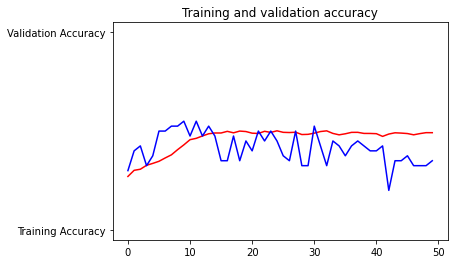

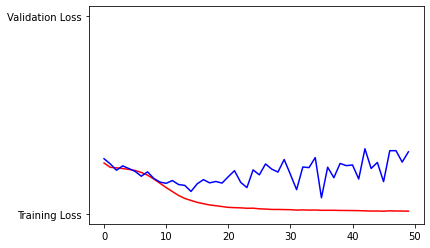

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

Drama (0.206)
Adventure (0.071)
Action (0.0321)


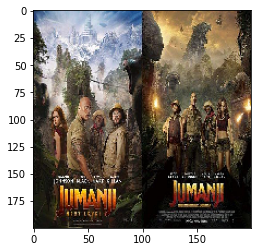

In [0]:
#View the top 3 genres for the assigned poster
img = image.load_img('poster-jumanji-the-next-level-2019.jpg',target_size=(200,200,3))
img = image.img_to_array(img)
img = img/255

classes = np.array(movieListDatabaseGenreencode.columns[2:])
proba = model.predict(img.reshape(1,200,200,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)